# Packages

In [1]:
using Distributions
using DataFrames
using GLM
using Pipe
using Query
using Turing
using StatsPlots

# Utility functions

In [2]:
inv_logit(x) = 1/(1 + exp(-x));
missing_fraction(x::Vector) = x .|> ismissing |> mean;

# Models

In [ ]:
α βstudent

In [3]:
iters = 10000;

In [4]:
@model function student_homework(student, homework)
    N = length(student)
    α ~ Normal(0, 1.5)
    βstudent ~ Normal(0, 0.5)
    
    for i in 1:N
        p = inv_logit(α + βstudent * student[i])
        homework[i] ~ Binomial(10, p)
    end
end;

In [5]:
@model function student_homework(student, homework, noise)
    N = length(student)
    α ~ Normal(0, 1.5)
    βstudent ~ Normal(0, 0.5)
    Βnoise ~ Normal(0, 1)
    
    for i in 1:N
        p = inv_logit(α + βstudent * student[i] + Βnoise * noise[i])
        homework[i] ~ Binomial(10, p)
    end
end;

For the linear version of the models, we assume no link function so the easiest thing to do is to asssume the target variable follows a normal distribution with mean $\mu$ and standard deviation 1, where $\mu$ is a linear function of the predictors.

In [6]:
@model function student_homework_linear(student, homework)
    N = length(student)
    α ~ Normal(0, 1.5)
    βstudent ~ Normal(0, 0.5)
    
    for i in 1:N
        p = α + βstudent * student[i]
        homework[i] ~ Normal(p)
    end
end;

In [7]:
@model function student_homework_linear(student, homework, noise)
    N = length(student)
    α ~ Normal(0, 1.5)
    βstudent ~ Normal(0, 0.5)
    Βnoise ~ Normal(0, 1)
    
    for i in 1:N
        p = α + βstudent * student[i] + Βnoise * noise[i]
        homework[i] ~ Normal(p)
    end
end;

# Dataset

Define dataset:

In [8]:
N = 10000
# latent ability of student, higher is better
S = @pipe Normal() |> rand(_, N)
# homework score on a 10-point scale base student's latent ability
H_true = @pipe Binomial.(10, inv_logit.(S)) .|> rand(_, 1) |> vcat(_...)

base = DataFrame(student_score = S, homework_score = H_true)
head(base, 5)

,student_score,homework_score
,Float64,Int64
1,-0.714767,2
2,0.138039,3
3,-0.235565,3
4,-0.618277,3
5,-1.61967,3


# Missing Data

## Scenario 1: Dog Randomly Eats Homework

If a dog randomly eats a homework:

In [9]:
# probability a dog will eat the homework
prob_eat = 0.5;

In [10]:
D = @pipe Bernoulli(prob_eat) |> rand(_, N)

random_dog = copy(base)
random_dog[!, :is_eaten] = D

random_dog = random_dog |>
    @mutate(homework_obs = ifelse(_.is_eaten, missing, _.homework_score)) |>
    DataFrame

head(random_dog, 5)

,student_score,homework_score,is_eaten,homework_obs
,Any,Any,Any,Any
1,-0.714767,2,1,missing
2,0.138039,3,1,missing
3,-0.235565,3,0,3
4,-0.618277,3,1,missing
5,-1.61967,3,0,3


In [11]:
describe(random_dog)

,variable,mean,min,median,max,nunique,nmissing
,Symbol,Float64,Real,Float64,Real,Int64,Int64
1,student_score,-0.00325815,-3.59284,-0.00258703,3.81311,10000,0
2,homework_score,4.9971,0,5.0,10,11,0
3,is_eaten,0.5005,0,1.0,1,2,0
4,homework_obs,4.97938,0,5.0,10,11,5005


Fraction of observations is missing:

In [12]:
missing_fraction(random_dog[:, :homework_obs])

0.5005

If we do inference and drop the missing values:

In [13]:
data_obs = random_dog |>
    @filter(_.is_eaten == false) |>
    DataFrame

student = data_obs[:, :student_score]
homework = data_obs[:, :homework_obs]

chain = sample(student_homework(student, homework), NUTS(), iters)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:09:49


Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α   -0.0026    0.0097     0.0001    0.0001   7578.9425    1.0000  
    βstudent    0.9813    0.0118     0.0001    0.0001   8284.6047    1.0005  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
   

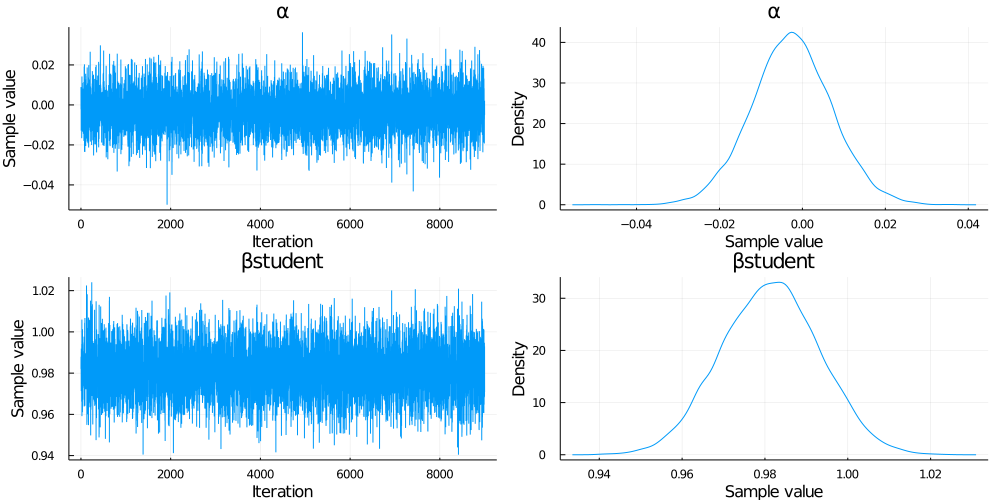

In [14]:
plot(chain)

If we had access to all of the homework scores...

In [15]:
student = random_dog[:, :student_score]
homework = random_dog[:, :homework_score]

chain = sample(student_homework(student, homework), NUTS(), iters)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hmc.jl:625
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltoni

Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α    0.0038    0.0069     0.0001    0.0001   9180.2389    1.0001  
    βstudent    0.9918    0.0083     0.0001    0.0001   8488.6789    0.9999  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
   

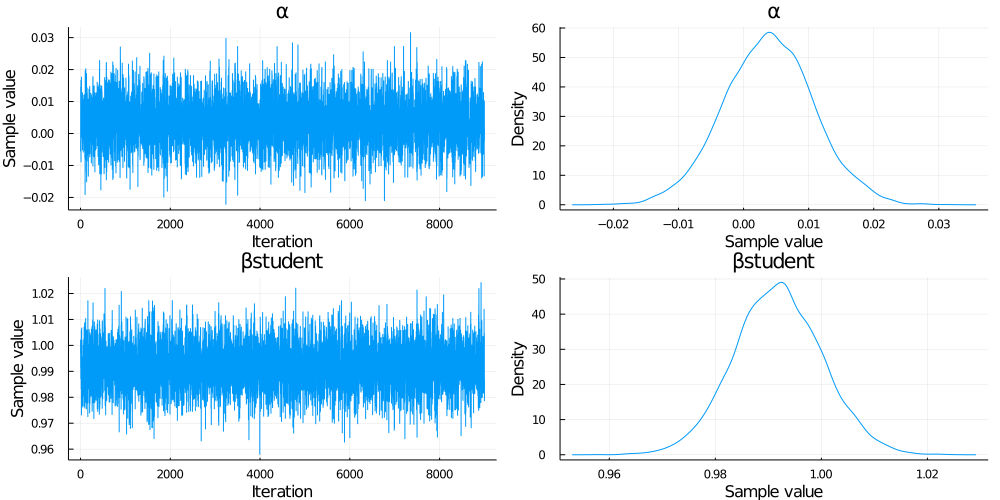

In [16]:
plot(chain)

## Scenario 2: Dog Eats High Score Student's Homework

If a student's score is more than 0, then the dog will eat the student's homework.

In [17]:
highscore_dog = copy(base)

highscore_dog = highscore_dog |>
    @mutate(is_eaten = ifelse(_.student_score > 0, true, false)) |>
    @mutate(homework_obs = ifelse(_.is_eaten, missing, _.homework_score)) |>
    DataFrame

head(highscore_dog, 5)

,student_score,homework_score,is_eaten,homework_obs
,Any,Any,Any,Any
1,-0.714767,2,0,2
2,0.138039,3,1,missing
3,-0.235565,3,0,3
4,-0.618277,3,0,3
5,-1.61967,3,0,3


In [18]:
missing_fraction(highscore_dog[:, :homework_obs])

0.499

Inference with missing values dropped:

In [19]:
data_obs = highscore_dog |>
    @filter(_.is_eaten == false) |>
    DataFrame

student = data_obs[:, :student_score]
homework = data_obs[:, :homework_obs]

chain = sample(student_homework(student, homework), NUTS(), iters)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hmc.jl:625
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltoni

Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α   -0.0228    0.0164     0.0002    0.0004   2061.5361    1.0000  
    βstudent    0.9603    0.0194     0.0002    0.0005   2023.3228    0.9999  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
   

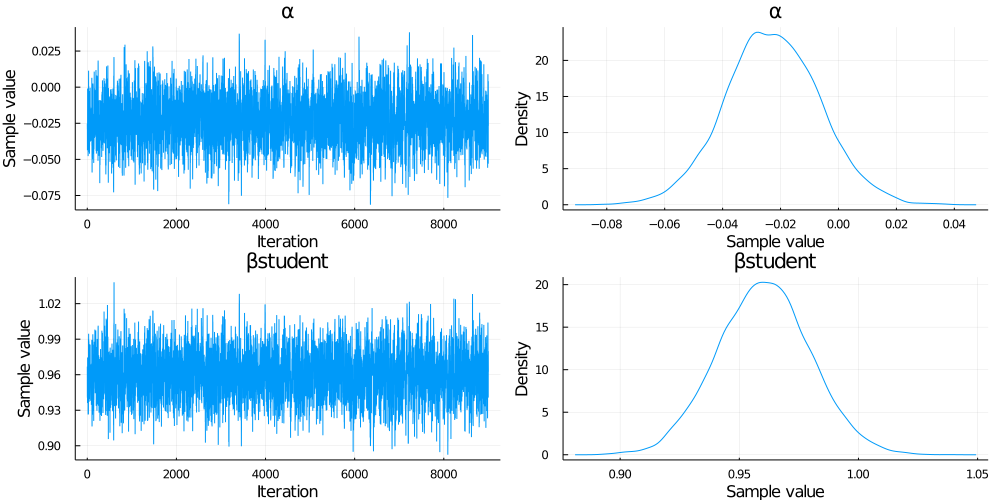

In [20]:
plot(chain)

Can still recover true parameters.

But, if the true relationship between homework score and student score changes when student score > 0, we won't be able to know this!

## Scenario 3: Intermediate variable influencing Homework Score and Dog

For example, let X be noise level in a house:

1. If the noise level in a house is high, students give bad homework, and
2. If the noise level in a house is high, dogs eat homework

In [21]:
noisy_home = copy(base)

noisy_home[:, :noise] = @pipe Normal() |> rand(_, N)

# influence of noise on homework score
noisy_home = noisy_home |>
    @mutate(p = inv_logit(2 + _.student_score - 2 * _.noise)) |>
    @mutate(homework_score = rand(Binomial(10, _.p)))

# influence of noise on whether dog eats the homework
noisy_home = noisy_home |>
    @mutate(is_eaten = ifelse(_.noise > 1, true, false)) |>
    @mutate(homework_obs = ifelse(_.is_eaten, missing, _.homework_score))


noisy_home = noisy_home |>
    @select(:student_score, :noise, :p, :homework_score, :is_eaten, :homework_obs) |>
    DataFrame

head(noisy_home, 5)

,student_score,noise,p,homework_score,is_eaten,homework_obs
,Float64,Float64,Float64,Int64,Bool,Int64?
1,-0.714767,-1.25283,0.977923,10,0,10
2,0.138039,-0.557997,0.962818,10,0,10
3,-0.235565,-0.926727,0.973862,10,0,10
4,-0.618277,-0.0906508,0.826787,10,0,10
5,-1.61967,0.114387,0.537816,4,0,4


If we do inference on the effect of student score on homework score assuming no missing values and we can observe noise:

In [22]:
student = noisy_home[:, :student_score]
homework = noisy_home[:, :homework_score]
noise = noisy_home[:, :noise]

chain = sample(student_homework(student, homework, noise), NUTS(), iters)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hm

Chains MCMC chain (9000×15×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = Βnoise, α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
      Βnoise   -1.9897    0.0147     0.0002    0.0002   4197.5095    1.0001  
           α    1.9854    0.0131     0.0001    0.0002   4169.3478    0.9999  
    βstudent    1.0018    0.0109     0.0001    0.0001   5782.8455    1.0000  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Fl

We can recover the true parameters.

If we assumed that the noise was not observable:

In [23]:
student = noisy_home[:, :student_score]
homework = noisy_home[:, :homework_score]

chain = sample(student_homework(student, homework), NUTS(), iters)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hm

Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α    1.2346    0.0081     0.0001    0.0001   7825.1260    0.9999  
    βstudent    0.6740    0.0083     0.0001    0.0001   7777.9569    1.0003  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
   

We cannot recover the true parameters even though `noise` does not confound student score and homework score.

See section `10.2.3 Omitted variable bias again` in the book for details.

What if we assume there is no link function?

In [24]:
noisy_home_linear = copy(noisy_home)

# influence of noise on homework score
noisy_home_linear = noisy_home_linear |>
    @mutate(p = 2 + _.student_score - 2 * _.noise) |>
    @mutate(homework_score = rand(Normal(_.p)))

# influence of noise on whether dog eats the homework
noisy_home_linear = noisy_home_linear |>
    @mutate(is_eaten = ifelse(_.noise > 1, true, false)) |>
    @mutate(homework_obs = ifelse(_.is_eaten, missing, _.homework_score))


noisy_home_linear = noisy_home_linear |>
    @select(:student_score, :noise, :p, :homework_score, :is_eaten, :homework_obs) |>
    DataFrame

head(noisy_home_linear, 5)

,student_score,noise,p,homework_score,is_eaten,homework_obs
,Float64,Float64,Float64,Float64,Bool,Float64?
1,-0.714767,-1.25283,3.79089,5.38699,0,5.38699
2,0.138039,-0.557997,3.25403,4.38808,0,4.38808
3,-0.235565,-0.926727,3.61789,2.69327,0,2.69327
4,-0.618277,-0.0906508,1.56302,0.843968,0,0.843968
5,-1.61967,0.114387,0.151553,0.314316,0,0.314316


Assuming noise is not observable:

In [25]:
student = noisy_home_linear[:, :student_score]
homework = noisy_home_linear[:, :homework_score]

chain = sample(student_homework_linear(student, homework), NUTS(), iters)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:11:07


Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α    1.9652    0.0100     0.0001    0.0001   8734.8089    1.0001  
    βstudent    1.0224    0.0101     0.0001    0.0001   8365.1684    1.0000  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
   

Assuming noise is observable:

In [26]:
student = noisy_home_linear[:, :student_score]
homework = noisy_home_linear[:, :homework_score]
noise = noisy_home_linear[:, :noise]

chain = sample(student_homework_linear(student, homework, noise), NUTS(), iters)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:12:26


Chains MCMC chain (9000×15×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = Βnoise, α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat  
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64  
                                                                              
      Βnoise   -1.9985    0.0101     0.0001    0.0001   12446.6449    0.9999  
           α    1.9973    0.0100     0.0001    0.0001   13133.4281    0.9999  
    βstudent    0.9939    0.0097     0.0001    0.0001   12914.0791    1.0000  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float6

When there is no link function, we can recover the true parameter i.e. the coefficient of student score regarless of the observability of noise.

Now, back to the original problem i.e. have link function.

We have seen that when noise is not observable, we can't recover the true parameters.

What is the impact of missing data?

In [27]:
missing_fraction(noisy_home[:, :homework_obs])

0.1579

In [28]:
data_obs = noisy_home |>
    @filter(_.is_eaten == false) |>
    DataFrame

student = data_obs[:, :student_score]
homework = data_obs[:, :homework_obs]

chain = sample(student_homework(student, homework), NUTS(), iters)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hmc.jl:625
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltoni

Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α    1.8569    0.0113     0.0001    0.0001   5257.1606    1.0003  
    βstudent    0.8305    0.0110     0.0001    0.0002   5003.3158    1.0006  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
   

It looks better than the one without missing data, but this is not always the case.

For example, we can change the function that the dog will eat a homework:

In [29]:
noisy_home_variant = copy(noisy_home)

# influence of noise on whether dog eats the homework
noisy_home_variant = noisy_home_variant |>
    @mutate(is_eaten = ifelse(abs(_.noise) < 0.2, true, false)) |>
    @mutate(homework_obs = ifelse(_.is_eaten, missing, _.homework_score))


noisy_home_variant = noisy_home_variant |>
    @select(:student_score, :noise, :p, :homework_score, :is_eaten, :homework_obs) |>
    DataFrame

head(noisy_home_variant, 5)

,student_score,noise,p,homework_score,is_eaten,homework_obs
,Float64,Float64,Float64,Int64,Bool,Int64?
1,-0.714767,-1.25283,0.977923,10,0,10
2,0.138039,-0.557997,0.962818,10,0,10
3,-0.235565,-0.926727,0.973862,10,0,10
4,-0.618277,-0.0906508,0.826787,10,1,missing
5,-1.61967,0.114387,0.537816,4,1,missing


In [30]:
missing_fraction(noisy_home_variant[:, :homework_obs])

0.1633

In [31]:
data_obs = noisy_home_variant |>
    @filter(_.is_eaten == false) |>
    DataFrame

student = data_obs[:, :student_score]
homework = data_obs[:, :homework_obs]

chain = sample(student_homework(student, homework), NUTS(), iters)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:12:18


Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α    1.1300    0.0085     0.0001    0.0001   7766.5770    1.0001  
    βstudent    0.6387    0.0088     0.0001    0.0001   8338.3388    0.9999  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
   

## Scenario 4: Homework influencing dog

For example, dogs prefer to eat bad homework.

In [32]:
badhw_dog = copy(base)

badhw_dog = badhw_dog |>
    @mutate(is_eaten = ifelse(_.homework_score < 5, true, false)) |>
    @mutate(homework_obs = ifelse(_.is_eaten, missing, _.homework_score)) |>
    DataFrame

head(badhw_dog, 5)

,student_score,homework_score,is_eaten,homework_obs
,Any,Any,Any,Any
1,-0.714767,2,1,missing
2,0.138039,3,1,missing
3,-0.235565,3,1,missing
4,-0.618277,3,1,missing
5,-1.61967,3,1,missing


In [33]:
 missing_fraction(badhw_dog[:, :homework_obs])

0.4376

If we do inference and ignore missing values;

In [34]:
data_obs = badhw_dog |>
    @filter(_.is_eaten == false) |>
    DataFrame

student = data_obs[:, :student_score]
homework = data_obs[:, :homework_obs]

chain = sample(student_homework(student, homework), NUTS(), iters)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hmc.jl:625
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltoni

Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α    0.4489    0.0110     0.0001    0.0002   4828.6790    0.9999  
    βstudent    0.6389    0.0130     0.0001    0.0002   4396.0753    0.9999  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
   

We are missing bad homework, so effect of student score on homework score is underestimated i.e. downward bias.

What if the dog instead eat the good homework?

In [35]:
goodhw_dog = copy(base)

goodhw_dog = goodhw_dog |>
    @mutate(is_eaten = ifelse(_.homework_score >= 5, true, false)) |>
    @mutate(homework_obs = ifelse(_.is_eaten, missing, _.homework_score)) |>
    DataFrame

data_obs = goodhw_dog |>
    @filter(_.is_eaten == false) |>
    DataFrame

student = data_obs[:, :student_score]
homework = data_obs[:, :homework_obs]

chain = sample(student_homework(student, homework), NUTS(), iters)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hmc.jl:625
Sampling: 100%|█████████████████████████████████████████| Time: 0:11:18


Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α   -0.6662    0.0153     0.0002    0.0002   3810.6257    0.9999  
    βstudent    0.5402    0.0165     0.0002    0.0003   3768.2615    1.0000  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
   

Back to the orginal problem, if we have no missing values:

In [36]:
student = badhw_dog[:, :student_score]
homework = badhw_dog[:, :homework_score]

chain = sample(student_homework(student, homework), NUTS(), iters)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/user/.julia/packages/Turing/493By/src/inference/hmc.jl:625
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/user/.julia/packages/AdvancedHMC/P9wqk/src/hamiltoni

Chains MCMC chain (9000×14×1 Array{Float64,3}):

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
parameters        = α, βstudent
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           α    0.0038    0.0070     0.0001    0.0001   9351.1923    1.0002  
    βstudent    0.9918    0.0082     0.0001    0.0001   9186.8455    0.9999  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      Symbol   Float64   Float64   Float64   Float64   Float64  
                                                                
   

Obviously, we expect to recover the true parameter.

What if we incorporate the knowledge of whether the homework was eaten or not?

Then, we need a way to impute missing values.... In particular, we need to know how to marginalize over the missing values.

In [ ]:
S → H → D → H*